## POS tagging using modified Viterbi

### Data Preparation

In [3]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [4]:
# reading the Universal tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [5]:
print(nltk_data[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [6]:
# Splitting into train and test
random.seed(1234)
train_set, valid_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(valid_set))
print(train_set[:40])

3718
196
[[('Lord', 'NOUN'), ('Chilver', 'NOUN'), (',', '.'), ('63-year-old', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('English', 'NOUN'), ('China', 'NOUN'), ('Clays', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-39', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('chemical', 'NOUN'), ('company', 'NOUN'), ('.', '.')], [('Five', 'NUM'), ('things', 'NOUN'), ('0', 'X'), ('you', 'PRON'), ('can', 'VERB'), ('do', 'VERB'), ('*T*-1', 'X'), ('for', 'ADP'), ('$', '.'), ('15,000', 'NUM'), ('*U*', 'X'), ('or', 'CONJ'), ('less', 'ADJ'), (':', '.')], [('If', 'ADP'), ('you', 'PRON'), ("'d", 'VERB'), ('really', 'ADV'), ('rather', 'ADV'), ('have', 'VERB'), ('a', 'DET'), ('Buick', 'NOUN'), (',', '.'), ('*', 'X'), ('do', 'VERB'), ("n't", 'ADV'), ('leave', 'VERB'), ('home', 'NOUN'), ('without', 'ADP'), ('the', 'DET'), ('American', 'NOUN'), ('Express', 'NOUN'), ('card', 'NOUN'), ('.', '.')], [('Fe

# EDA

In [7]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95921

In [8]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Lord',
 'Chilver',
 ',',
 '63-year-old',
 'chairman',
 'of',
 'English',
 'China',
 'Clays',
 'PLC']

In [9]:
# vocabulary
V = set(tokens)
print(len(V))

12069


In [10]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [11]:
#print the tags
print(T)

{'PRON', '.', 'X', 'PRT', 'DET', 'NUM', 'ADJ', 'ADV', 'NOUN', 'VERB', 'ADP', 'CONJ'}


In [12]:
# number of X tags
Tag_X = [pair[1] for pair in train_tagged_words if pair[1]=='X']
len(Tag_X)

6310

In [13]:
# number of X tags and * in words
Tag_X_star = [pair for pair in train_tagged_words if pair[1]=='X' and '*' in pair[0]]
len(Tag_X_star)

5242

In [14]:
# number of Xtags and 0 as word
Tag_X_0 = [pair for pair in train_tagged_words if pair[1]=='X' and pair[0]=='0']
len(Tag_X_0)

1047

In [15]:
# number of X tags and numbers as word
Tag_X_Number = [pair for pair in train_tagged_words if pair[1]=='X' and pair[0]=='0' and pair[0].isnumeric() ]
len(Tag_X_Number)

1047

In [16]:
#tags and their frequencies
tag_fd = nltk.FreqDist(tag for (word, tag) in train_tagged_words)
tag_fd.most_common()

[('NOUN', 27463),
 ('VERB', 12921),
 ('.', 11155),
 ('ADP', 9381),
 ('DET', 8310),
 ('X', 6310),
 ('ADJ', 6101),
 ('NUM', 3417),
 ('PRT', 3082),
 ('ADV', 3001),
 ('PRON', 2612),
 ('CONJ', 2168)]

In [17]:
# tags before NOUN or other tags
word_tag_pairs = nltk.bigrams(train_tagged_words)
noun_preceders = [a[1] for (a, b) in word_tag_pairs if b[1] == 'NOUN']
fdist = nltk.FreqDist(noun_preceders)
[tag for (tag, _) in fdist.most_common()]

['NOUN',
 'DET',
 'ADJ',
 'ADP',
 '.',
 'VERB',
 'NUM',
 'CONJ',
 'PRT',
 'PRON',
 'X',
 'ADV']

In [18]:
#word been tagged as mention tag
word_tag_fd = nltk.FreqDist(train_tagged_words)
tagged_words_list = [wt[0] for (wt, _) in word_tag_fd.most_common() if wt[1] == 'NOUN']
tagged_words_list

['%',
 'Mr.',
 'company',
 'U.S.',
 'year',
 'market',
 'New',
 'trading',
 'stock',
 'president',
 'program',
 'share',
 'years',
 'Corp.',
 'shares',
 'York',
 'Inc.',
 'government',
 'prices',
 'business',
 'Japan',
 'Co.',
 'cents',
 'funds',
 'index',
 'price',
 'stocks',
 'investors',
 'companies',
 'time',
 'October',
 'futures',
 'yesterday',
 'Mrs.',
 'months',
 'sales',
 'bonds',
 'yen',
 'interest',
 'people',
 'House',
 'money',
 'investment',
 'week',
 'profit',
 'issue',
 'banks',
 'markets',
 'Exchange',
 'days',
 'traders',
 'rates',
 'officials',
 'Tuesday',
 'debt',
 'Congress',
 'country',
 'Bush',
 'chairman',
 'number',
 'Department',
 'vice',
 'plan',
 'month',
 'income',
 'September',
 'rate',
 'cash',
 'Chicago',
 'Board',
 'concern',
 'part',
 'investor',
 'Treasury',
 'Street',
 'firm',
 'group',
 'chief',
 'executive',
 'American',
 'South',
 'Yeargin',
 'spokesman',
 'industry',
 'Wall',
 'managers',
 'Columbia',
 'earnings',
 'issues',
 'Stock',
 'bank',
 '

In [19]:
#Get all the last four characters suffixes
all_suffixes = [tagged_word[-4:] for tagged_word in tagged_words_list]
all_suffixes

['%',
 'Mr.',
 'pany',
 'U.S.',
 'year',
 'rket',
 'New',
 'ding',
 'tock',
 'dent',
 'gram',
 'hare',
 'ears',
 'orp.',
 'ares',
 'York',
 'Inc.',
 'ment',
 'ices',
 'ness',
 'apan',
 'Co.',
 'ents',
 'unds',
 'ndex',
 'rice',
 'ocks',
 'tors',
 'nies',
 'time',
 'ober',
 'ures',
 'rday',
 'Mrs.',
 'nths',
 'ales',
 'onds',
 'yen',
 'rest',
 'ople',
 'ouse',
 'oney',
 'ment',
 'week',
 'ofit',
 'ssue',
 'anks',
 'kets',
 'ange',
 'days',
 'ders',
 'ates',
 'ials',
 'sday',
 'debt',
 'ress',
 'ntry',
 'Bush',
 'rman',
 'mber',
 'ment',
 'vice',
 'plan',
 'onth',
 'come',
 'mber',
 'rate',
 'cash',
 'cago',
 'oard',
 'cern',
 'part',
 'stor',
 'sury',
 'reet',
 'firm',
 'roup',
 'hief',
 'tive',
 'ican',
 'outh',
 'rgin',
 'sman',
 'stry',
 'Wall',
 'gers',
 'mbia',
 'ings',
 'sues',
 'tock',
 'bank',
 'rter',
 'rade',
 'ffer',
 'ourt',
 'irst',
 'ract',
 'owth',
 'Cray',
 'law',
 'John',
 'unit',
 'test',
 'ties',
 'irms',
 'ctor',
 'ital',
 'S&P',
 'bill',
 'arch',
 'Bank',
 'tion',
 

In [20]:
# suffixes and their frequencies
suffix_fd = nltk.FreqDist(suf for suf in all_suffixes)
suffix_fd.most_common()

[('tion', 216),
 ('ions', 125),
 ('ment', 78),
 ('ents', 52),
 ('ters', 45),
 ('ings', 44),
 ('ance', 42),
 ('sion', 38),
 ('tors', 36),
 ('ence', 34),
 ('ties', 33),
 ('ders', 29),
 ('ding', 27),
 ('ting', 27),
 ('lity', 24),
 ('ture', 24),
 ('ling', 24),
 ('ness', 23),
 ('ight', 21),
 ('ries', 21),
 ('land', 21),
 ('kers', 21),
 ('ates', 20),
 ('ners', 20),
 ('ures', 19),
 ('ines', 18),
 ('sing', 17),
 ('ning', 17),
 ('ists', 17),
 ('ship', 17),
 ('ster', 17),
 ('ring', 15),
 ('rity', 15),
 ('ages', 15),
 ('nces', 15),
 ('king', 14),
 ('ants', 14),
 ('ices', 13),
 ('rage', 13),
 ('ives', 13),
 ('hing', 13),
 ('tory', 13),
 ('tive', 12),
 ('ctor', 12),
 ('yers', 12),
 ('orts', 12),
 ('ials', 11),
 ('rman', 11),
 ('gers', 11),
 ('mers', 11),
 ('lers', 11),
 ('line', 11),
 ('ille', 11),
 ('ches', 11),
 ('nder', 11),
 ('ator', 11),
 ('cies', 11),
 ('nger', 11),
 ('rter', 10),
 ('port', 10),
 ('ison', 10),
 ('gton', 10),
 ('ency', 10),
 ('rain', 10),
 ('ards', 10),
 ('ound', 10),
 ('tics'

###  Emission Probabilities

In [21]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [22]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

### Transition Probabilities

In [23]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [24]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [25]:
tags_matrix

array([[7.65696773e-03, 4.17304747e-02, 9.07350704e-02, 1.22511489e-02,
        9.95405857e-03, 6.50842255e-03, 7.46554360e-02, 3.36906575e-02,
        2.10566610e-01, 4.84303206e-01, 2.33537517e-02, 4.59418073e-03],
       [6.61586747e-02, 9.36799645e-02, 2.73419991e-02, 2.42043915e-03,
        1.72747642e-01, 8.22052881e-02, 4.50918861e-02, 5.24428524e-02,
        2.20528916e-01, 8.80322754e-02, 9.08112973e-02, 5.84491268e-02],
       [5.53090349e-02, 1.63391441e-01, 7.48018995e-02, 1.86053887e-01,
        5.49920760e-02, 2.69413623e-03, 1.64817758e-02, 2.59904917e-02,
        6.16481788e-02, 2.03961968e-01, 1.44057050e-01, 1.06180664e-02],
       [1.88189484e-02, 4.38027270e-02, 1.36275142e-02, 1.62232318e-03,
        9.70149264e-02, 5.84036335e-02, 8.46852660e-02, 1.00584039e-02,
        2.45944187e-01, 4.03958470e-01, 2.01168079e-02, 1.94678782e-03],
       [3.48977139e-03, 1.73285194e-02, 4.57280390e-02, 2.40673893e-04,
        5.53549919e-03, 2.26233453e-02, 2.05174491e-01, 1.23

In [26]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [27]:
tags_df

,PRON,.,X,PRT,DET,NUM,ADJ,ADV,NOUN,VERB,ADP,CONJ
PRON,0.007657,0.041730,0.090735,0.012251,0.009954,0.006508,0.074655,0.033691,0.210567,0.484303,0.023354,0.004594
.,0.066159,0.093680,0.027342,0.002420,0.172748,0.082205,0.045092,0.052443,0.220529,0.088032,0.090811,0.058449
X,0.055309,0.163391,0.074802,0.186054,0.054992,0.002694,0.016482,0.025990,0.061648,0.203962,0.144057,0.010618
PRT,0.018819,0.043803,0.013628,0.001622,0.097015,0.058404,0.084685,0.010058,0.245944,0.403958,0.020117,0.001947
DET,0.003490,0.017329,0.045728,0.000241,0.005535,0.022623,0.205174,0.012395,0.638026,0.039471,0.009507,0.000481
NUM,0.001463,0.116184,0.211004,0.027510,0.003219,0.185836,0.033070,0.002927,0.351771,0.018437,0.034533,0.014047
ADJ,0.000656,0.065235,0.021144,0.010654,0.004917,0.020980,0.067530,0.004753,0.697591,0.011965,0.077364,0.017210
ADV,0.014995,0.133955,0.021993,0.012662,0.068644,0.032989,0.129957,0.078640,0.033322,0.347884,0.118627,0.006331
NOUN,0.004479,0.239522,0.029239,0.044496,0.013291,0.009431,0.012307,0.016859,0.263518,0.146816,0.177220,0.042821
VERB,0.035601,0.035291,0.217630,0.030880,0.135516,0.023063,0.064778,0.081340,0.110905,0.168563,0.091015,0.005418


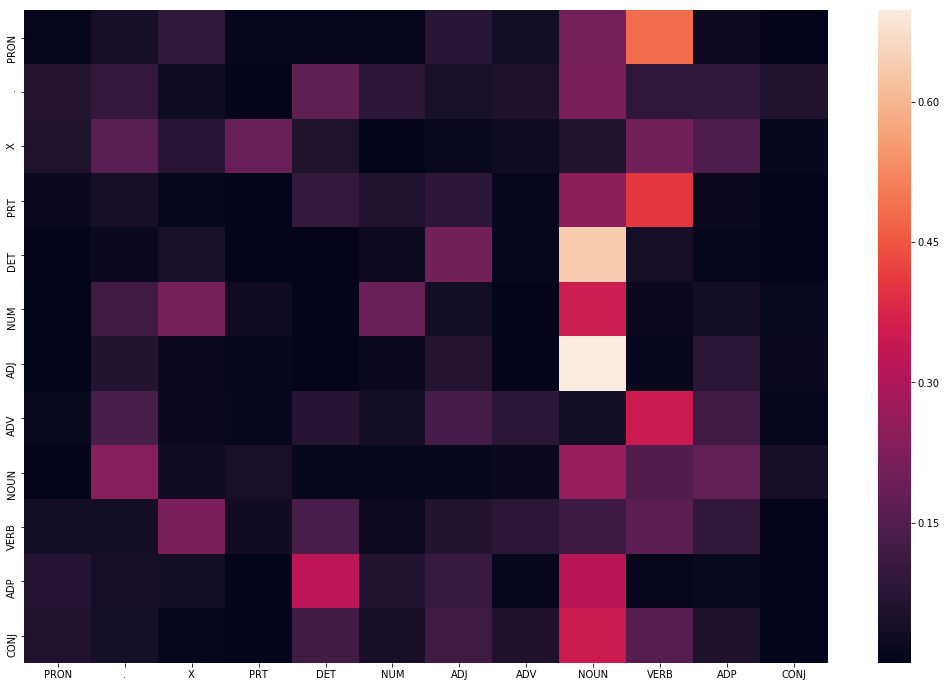

In [28]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

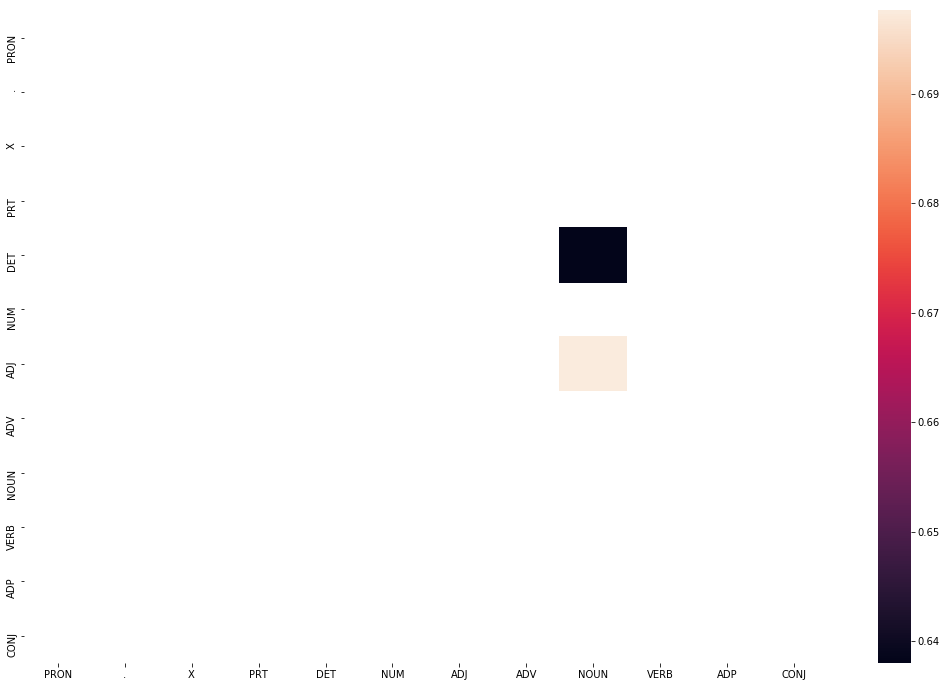

In [29]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

### Build the vanilla Viterbi based POS tagger

In [30]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

### Evaluating on Validation Set

In [31]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

# list of tagged words
valid_run_base = [tup for sent in valid_set for tup in sent]

# list of untagged words
valid_tagged_words = [tup[0] for sent in valid_set for tup in sent]

In [32]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(valid_tagged_words)
end = time.time()
difference = end-start

In [33]:
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(valid_run_base)

Time taken in seconds:  859.3080809116364
[('Fees', 'NOUN'), ('1', 'NUM'), ('3\\/4', 'NUM'), ('.', '.'), ('What', 'PRON'), ('*T*-42', 'X'), ('saved', 'PRON'), ('many', 'ADJ'), ('farmers', 'NOUN'), ('from', 'ADP'), ('a', 'DET'), ('bad', 'ADJ'), ('year', 'NOUN'), ('was', 'VERB'), ('the', 'DET'), ('opportunity', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('reclaim', 'PRON'), ('large', 'ADJ'), ('quantities', 'NOUN'), ('of', 'ADP'), ('grain', 'NOUN'), ('and', 'CONJ'), ('other', 'ADJ'), ('crops', 'NOUN'), ('that', 'ADP'), ('they', 'PRON'), ('had', 'VERB'), ('``', '.'), ('mortgaged', 'PRON'), ("''", '.'), ('*T*-1', 'X'), ('to', 'PRT'), ('the', 'DET'), ('government', 'NOUN'), ('under', 'ADP'), ('price-support', 'PRON'), ('loan', 'NOUN'), ('programs', 'NOUN'), ('.', '.'), ('The', 'DET'), ('new', 'ADJ'), ('ad', 'NOUN'), ('plan', 'NOUN'), ('from', 'ADP'), ('Newsweek', 'NOUN'), (',', '.'), ('a', 'DET'), ('unit', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('Washington', 'NOUN'), ('Post', 'PRON'), ('Co.', 'NO

In [34]:
# accuracy
check = [i for i, j in zip(tagged_seq, valid_run_base) if i == j] 

In [35]:
accuracy = len(check)/len(tagged_seq)

In [36]:
accuracy

0.9011566771819137

In [37]:
incorrect_tagged_cases = [[valid_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, valid_run_base)) if j[0]!=j[1]]

In [38]:
incorrect_tagged_cases

[[('*T*-42', 'X'), (('saved', 'PRON'), ('saved', 'VERB'))],
 [('to', 'PRT'), (('reclaim', 'PRON'), ('reclaim', 'VERB'))],
 [('``', '.'), (('mortgaged', 'PRON'), ('mortgaged', 'VERB'))],
 [('under', 'ADP'), (('price-support', 'PRON'), ('price-support', 'ADJ'))],
 [('Washington', 'NOUN'), (('Post', 'PRON'), ('Post', 'NOUN'))],
 [('be', 'VERB'), (('injuring', 'PRON'), ('injuring', 'VERB'))],
 [('Oct.', 'NOUN'), (('2-8', 'PRON'), ('2-8', 'NUM'))],
 [('year', 'NOUN'), (('ago', 'ADP'), ('ago', 'ADV'))],
 [('to', 'PRT'), (('A.C.', 'PRON'), ('A.C.', 'NOUN'))],
 [('A.C.', 'NOUN'), (('Nielsen', 'PRON'), ('Nielsen', 'NOUN'))],
 [('bone', 'NOUN'), (('marrow', 'PRON'), ('marrow', 'NOUN'))],
 [('other', 'ADJ'), (('blood-cell', 'PRON'), ('blood-cell', 'NOUN'))],
 [('makes', 'VERB'), (('rechargeable', 'PRON'), ('rechargeable', 'ADJ'))],
 [('nickel', 'NOUN'), (('cadmium', 'PRON'), ('cadmium', 'NOUN'))],
 [('and', 'CONJ'), (('carbon', 'PRON'), ('carbon', 'NOUN'))],
 [('carbon', 'NOUN'), (('zinc', 'PRON'

### Solve the problem of unknown words

# Solution No. 1

##### Modified Viterbi

In [39]:
#Here put a logic if word count for a given tag is 0 then use alpha value to emission probabilities
#alpha is a very small value (almost negligible)
#try different value of alpha
#like alpha=0.01,0.001,0.0001 etc.
#Here I am taking alpha as 0.000001
#alpha value is very less so state_probability depends only on tag given previous tag

In [40]:
# Viterbi Heuristic
alpha = 0.000001
def Viterbi_Mod_1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            if word_given_tag(words[key], tag)[0]!=0:
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            else:
                emission_p = alpha
                
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        if pmax!=alpha:
        # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
        else:
            state.append("NOUN")
    return list(zip(words, state))

In [41]:
# tagging the test sentences
start = time.time()
tagged_seq_1 = Viterbi_Mod_1(valid_tagged_words)
end = time.time()
difference = end-start

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

#### Evaluating tagging accuracy

In [42]:
# accuracy
check = [i for i, j in zip(tagged_seq_1, valid_run_base) if i == j] 

In [43]:
accuracy = len(check)/len(tagged_seq_1)

In [44]:
accuracy

0.9345951629863302

In [45]:
incorrect_tagged_cases_1 = [[valid_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_1, valid_run_base)) if j[0]!=j[1]]

In [46]:
incorrect_tagged_cases_1

[[('``', '.'), (('mortgaged', 'NOUN'), ('mortgaged', 'VERB'))],
 [('under', 'ADP'), (('price-support', 'DET'), ('price-support', 'ADJ'))],
 [('be', 'VERB'), (('injuring', 'X'), ('injuring', 'VERB'))],
 [('Oct.', 'NOUN'), (('2-8', 'NOUN'), ('2-8', 'NUM'))],
 [('year', 'NOUN'), (('ago', 'ADP'), ('ago', 'ADV'))],
 [('to', 'PRT'), (('A.C.', 'VERB'), ('A.C.', 'NOUN'))],
 [('A.C.', 'NOUN'), (('Nielsen', 'X'), ('Nielsen', 'NOUN'))],
 [('makes', 'VERB'), (('rechargeable', 'X'), ('rechargeable', 'ADJ'))],
 [('.', '.'), (('Three', 'NOUN'), ('Three', 'NUM'))],
 [('at', 'ADP'), (('American', 'ADJ'), ('American', 'NOUN'))],
 [('companies', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('.', '.'), (('Performing', 'NOUN'), ('Performing', 'VERB'))],
 [('the', 'DET'), (('most', 'ADJ'), ('most', 'ADV'))],
 [('its', 'PRON'), (('merits', 'VERB'), ('merits', 'NOUN'))],
 [('firms', 'NOUN'), (('championing', 'NOUN'), ('championing', 'VERB'))],
 [('.', '.'), (('So', 'ADV'), ('So', 'ADP'))],
 [('which', 'DET

###  List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [47]:
improved_tags = [[valid_run_base[i],j] for i, j in enumerate(zip(tagged_seq,valid_run_base, tagged_seq_1)) if j[0]!=j[1] and j[1]==j[2]] 

In [48]:
improved_tags

[[('saved', 'VERB'),
  (('saved', 'PRON'), ('saved', 'VERB'), ('saved', 'VERB'))],
 [('reclaim', 'VERB'),
  (('reclaim', 'PRON'), ('reclaim', 'VERB'), ('reclaim', 'VERB'))],
 [('Post', 'NOUN'), (('Post', 'PRON'), ('Post', 'NOUN'), ('Post', 'NOUN'))],
 [('marrow', 'NOUN'),
  (('marrow', 'PRON'), ('marrow', 'NOUN'), ('marrow', 'NOUN'))],
 [('blood-cell', 'NOUN'),
  (('blood-cell', 'PRON'), ('blood-cell', 'NOUN'), ('blood-cell', 'NOUN'))],
 [('cadmium', 'NOUN'),
  (('cadmium', 'PRON'), ('cadmium', 'NOUN'), ('cadmium', 'NOUN'))],
 [('carbon', 'NOUN'),
  (('carbon', 'PRON'), ('carbon', 'NOUN'), ('carbon', 'NOUN'))],
 [('zinc', 'NOUN'), (('zinc', 'PRON'), ('zinc', 'NOUN'), ('zinc', 'NOUN'))],
 [('abolishing', 'VERB'),
  (('abolishing', 'PRON'), ('abolishing', 'VERB'), ('abolishing', 'VERB'))],
 [('lifting', 'NOUN'),
  (('lifting', 'PRON'), ('lifting', 'NOUN'), ('lifting', 'NOUN'))],
 [('blindfold', 'NOUN'),
  (('blindfold', 'PRON'), ('blindfold', 'NOUN'), ('blindfold', 'NOUN'))],
 [('recomme

# Solution No. 2

In [2028]:
#Here it is been considered that Unknown words are belong to open class tags (NOUN,ADJ,ADV,VERB)
#So discard other tags
# Words contain * are been tagged as X
#If the word is absence for given tag then this word is most probably belongs to open class words

In [50]:
alpha = 0.000001
def Viterbi_Mod_2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            elif '*' in words[key]:
                state.append('X')
                break
            elif word_given_tag(words[key], tag)[0]==0:
                if tag in ['NOUN', 'ADJ','ADV','VERB']:
                    transition_p = tags_df.loc[state[-1], tag]
                    emission_p = alpha
                else:
                    transition_p = 0
                    emission_p = 0
            else:
                transition_p = tags_df.loc[state[-1], tag]
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
             
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        if '*' not in words[key]:   
            pmax = max(p)
            # getting state for which probability is maximum
            if pmax!=alpha:
                state_max = T[p.index(pmax)] 
                state.append(state_max)
            else:
                state.append("NOUN")
    return list(zip(words, state))

In [51]:
# tagging the test sentences
start = time.time()
tagged_seq_2 = Viterbi_Mod_2(valid_tagged_words)
end = time.time()
difference = end-start

In [52]:
print("Time taken in seconds: ", difference)
print(tagged_seq_2)
#print(valid_run_base)

Time taken in seconds:  509.8195266723633
[('Fees', 'NOUN'), ('1', 'NUM'), ('3\\/4', 'NUM'), ('.', '.'), ('What', 'PRON'), ('*T*-42', 'X'), ('saved', 'VERB'), ('many', 'ADJ'), ('farmers', 'NOUN'), ('from', 'ADP'), ('a', 'DET'), ('bad', 'ADJ'), ('year', 'NOUN'), ('was', 'VERB'), ('the', 'DET'), ('opportunity', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('reclaim', 'VERB'), ('large', 'ADJ'), ('quantities', 'NOUN'), ('of', 'ADP'), ('grain', 'NOUN'), ('and', 'CONJ'), ('other', 'ADJ'), ('crops', 'NOUN'), ('that', 'ADP'), ('they', 'PRON'), ('had', 'VERB'), ('``', '.'), ('mortgaged', 'NOUN'), ("''", '.'), ('*T*-1', 'X'), ('to', 'PRT'), ('the', 'DET'), ('government', 'NOUN'), ('under', 'ADP'), ('price-support', 'NOUN'), ('loan', 'NOUN'), ('programs', 'NOUN'), ('.', '.'), ('The', 'DET'), ('new', 'ADJ'), ('ad', 'NOUN'), ('plan', 'NOUN'), ('from', 'ADP'), ('Newsweek', 'NOUN'), (',', '.'), ('a', 'DET'), ('unit', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('Washington', 'NOUN'), ('Post', 'NOUN'), ('Co.', 'NO

###  Evaluating tagging accuracy

In [53]:
# accuracy
check = [i for i, j in zip(tagged_seq_2, valid_run_base) if i == j]

In [54]:
accuracy = len(check)/len(tagged_seq_2)

In [55]:
accuracy

0.9446898002103049

In [56]:
incorrect_tagged_cases_2 = [[valid_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_2, valid_run_base)) if j[0]!=j[1]]

In [57]:
incorrect_tagged_cases_2

[[('``', '.'), (('mortgaged', 'NOUN'), ('mortgaged', 'VERB'))],
 [('under', 'ADP'), (('price-support', 'NOUN'), ('price-support', 'ADJ'))],
 [('Oct.', 'NOUN'), (('2-8', 'NOUN'), ('2-8', 'NUM'))],
 [('year', 'NOUN'), (('ago', 'ADP'), ('ago', 'ADV'))],
 [('to', 'PRT'), (('A.C.', 'VERB'), ('A.C.', 'NOUN'))],
 [('A.C.', 'NOUN'), (('Nielsen', 'VERB'), ('Nielsen', 'NOUN'))],
 [('makes', 'VERB'), (('rechargeable', 'VERB'), ('rechargeable', 'ADJ'))],
 [('.', '.'), (('Three', 'NOUN'), ('Three', 'NUM'))],
 [('at', 'ADP'), (('American', 'ADJ'), ('American', 'NOUN'))],
 [('companies', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('.', '.'), (('Performing', 'NOUN'), ('Performing', 'VERB'))],
 [('the', 'DET'), (('most', 'ADJ'), ('most', 'ADV'))],
 [('its', 'PRON'), (('merits', 'VERB'), ('merits', 'NOUN'))],
 [('firms', 'NOUN'), (('championing', 'NOUN'), ('championing', 'VERB'))],
 [('.', '.'), (('So', 'ADV'), ('So', 'ADP'))],
 [('a', 'DET'), (('four-year', 'NOUN'), ('four-year', 'ADJ'))],
 [('$',

###  List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [58]:
improved_tags_2 = [[valid_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq,valid_run_base, tagged_seq_2)) if j[0]!=j[1] and j[1]==j[2]] 

In [59]:
improved_tags_2

[[('*T*-42', 'X'), (('saved', 'PRON'), ('saved', 'VERB'), ('saved', 'VERB'))],
 [('to', 'PRT'),
  (('reclaim', 'PRON'), ('reclaim', 'VERB'), ('reclaim', 'VERB'))],
 [('Washington', 'NOUN'),
  (('Post', 'PRON'), ('Post', 'NOUN'), ('Post', 'NOUN'))],
 [('be', 'VERB'),
  (('injuring', 'PRON'), ('injuring', 'VERB'), ('injuring', 'VERB'))],
 [('bone', 'NOUN'),
  (('marrow', 'PRON'), ('marrow', 'NOUN'), ('marrow', 'NOUN'))],
 [('other', 'ADJ'),
  (('blood-cell', 'PRON'), ('blood-cell', 'NOUN'), ('blood-cell', 'NOUN'))],
 [('nickel', 'NOUN'),
  (('cadmium', 'PRON'), ('cadmium', 'NOUN'), ('cadmium', 'NOUN'))],
 [('and', 'CONJ'),
  (('carbon', 'PRON'), ('carbon', 'NOUN'), ('carbon', 'NOUN'))],
 [('carbon', 'NOUN'), (('zinc', 'PRON'), ('zinc', 'NOUN'), ('zinc', 'NOUN'))],
 [('*', 'X'),
  (('abolishing', 'PRON'), ('abolishing', 'VERB'), ('abolishing', 'VERB'))],
 [('which', 'DET'), (('*T*-259', 'PRON'), ('*T*-259', 'X'), ('*T*-259', 'X'))],
 [('first', 'ADJ'),
  (('lifting', 'PRON'), ('lifting', 

## Taging Based on Solution No. 1

In [60]:
raw = open("Test_sentences.txt").read()

In [61]:
from nltk.tokenize import word_tokenize
words = word_tokenize(raw)

In [62]:
# tagging the test sentences
start = time.time()
tagged_seq_1_new = Viterbi_Mod_1(words)
end = time.time()
difference = end-start

In [63]:
print(tagged_seq_1_new)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('user

# More Solutions

# Solution No. 3

In [64]:
#For Unknown Words emission probability calculation is done using Laplace Smoothing
#Define
#P(w|c)=(count(w,c)+1)/count(c)+|V|,
#where V refers to the vocabulary (the words in the training set).
#In particular, any unknown word will have probability
#1/count(c)+|V|+1.

In [65]:
# Viterbi Heuristic
def Viterbi_Mod_3(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            if word_given_tag(words[key], tag)[0]!=0:
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            else:
                laplace = 1/ (1+ (len(train_tagged_words) + word_given_tag(words[key], tag)[1]))
                emission_p = laplace
                
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        if pmax!=laplace:
            state_max = T[p.index(pmax)] 
            state.append(state_max)
        else:
            state.append("NOUN")
    return list(zip(words, state))

In [66]:
# tagging the test sentences
start = time.time()
tagged_seq_3 = Viterbi_Mod_3(valid_tagged_words)
end = time.time()
difference = end-start

In [67]:
print("Time taken in seconds: ", difference)
print(tagged_seq_3)
#print(valid_run_base)

Time taken in seconds:  955.7884004116058
[('Fees', 'NOUN'), ('1', 'NUM'), ('3\\/4', 'NUM'), ('.', '.'), ('What', 'PRON'), ('*T*-42', 'X'), ('saved', 'PRT'), ('many', 'ADJ'), ('farmers', 'NOUN'), ('from', 'ADP'), ('a', 'DET'), ('bad', 'ADJ'), ('year', 'NOUN'), ('was', 'VERB'), ('the', 'DET'), ('opportunity', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('reclaim', 'VERB'), ('large', 'ADJ'), ('quantities', 'NOUN'), ('of', 'ADP'), ('grain', 'NOUN'), ('and', 'CONJ'), ('other', 'ADJ'), ('crops', 'NOUN'), ('that', 'ADP'), ('they', 'PRON'), ('had', 'VERB'), ('``', '.'), ('mortgaged', 'NOUN'), ("''", '.'), ('*T*-1', 'X'), ('to', 'PRT'), ('the', 'DET'), ('government', 'NOUN'), ('under', 'ADP'), ('price-support', 'DET'), ('loan', 'NOUN'), ('programs', 'NOUN'), ('.', '.'), ('The', 'DET'), ('new', 'ADJ'), ('ad', 'NOUN'), ('plan', 'NOUN'), ('from', 'ADP'), ('Newsweek', 'NOUN'), (',', '.'), ('a', 'DET'), ('unit', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('Washington', 'NOUN'), ('Post', '.'), ('Co.', 'NOUN'),

#### Evaluating tagging accuracy

In [70]:
# accuracy
check = [i for i, j in zip(tagged_seq_3, valid_run_base) if i == j] 

In [71]:
accuracy = len(check)/len(tagged_seq_3)

In [72]:
accuracy

0.9245005257623554

In [73]:
incorrect_tagged_cases_3 = [[valid_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_3, valid_run_base)) if j[0]!=j[1]]

In [74]:
incorrect_tagged_cases_3

[[('*T*-42', 'X'), (('saved', 'PRT'), ('saved', 'VERB'))],
 [('``', '.'), (('mortgaged', 'NOUN'), ('mortgaged', 'VERB'))],
 [('under', 'ADP'), (('price-support', 'DET'), ('price-support', 'ADJ'))],
 [('Washington', 'NOUN'), (('Post', '.'), ('Post', 'NOUN'))],
 [('be', 'VERB'), (('injuring', 'X'), ('injuring', 'VERB'))],
 [('Oct.', 'NOUN'), (('2-8', '.'), ('2-8', 'NUM'))],
 [('year', 'NOUN'), (('ago', 'ADP'), ('ago', 'ADV'))],
 [('to', 'PRT'), (('A.C.', 'VERB'), ('A.C.', 'NOUN'))],
 [('A.C.', 'NOUN'), (('Nielsen', 'X'), ('Nielsen', 'NOUN'))],
 [('bone', 'NOUN'), (('marrow', '.'), ('marrow', 'NOUN'))],
 [('makes', 'VERB'), (('rechargeable', 'X'), ('rechargeable', 'ADJ'))],
 [('nickel', 'NOUN'), (('cadmium', '.'), ('cadmium', 'NOUN'))],
 [('carbon', 'NOUN'), (('zinc', '.'), ('zinc', 'NOUN'))],
 [('.', '.'), (('Three', 'NOUN'), ('Three', 'NUM'))],
 [('at', 'ADP'), (('American', 'ADJ'), ('American', 'NOUN'))],
 [('companies', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('.', '.'), (('Pe

###  List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [75]:
improved_tags_3 = [[valid_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq,valid_run_base, tagged_seq_3)) if j[0]!=j[1] and j[1]==j[2]] 

In [76]:
improved_tags_3

[[('to', 'PRT'),
  (('reclaim', 'PRON'), ('reclaim', 'VERB'), ('reclaim', 'VERB'))],
 [('other', 'ADJ'),
  (('blood-cell', 'PRON'), ('blood-cell', 'NOUN'), ('blood-cell', 'NOUN'))],
 [('and', 'CONJ'),
  (('carbon', 'PRON'), ('carbon', 'NOUN'), ('carbon', 'NOUN'))],
 [('first', 'ADJ'),
  (('lifting', 'PRON'), ('lifting', 'NOUN'), ('lifting', 'NOUN'))],
 [('``', '.'),
  (('blindfold', 'PRON'), ('blindfold', 'NOUN'), ('blindfold', 'NOUN'))],
 [('.', '.'), (('Heating', 'PRON'), ('Heating', 'NOUN'), ('Heating', 'NOUN'))],
 [('unauthorized', 'ADJ'),
  (('showings', 'PRON'), ('showings', 'NOUN'), ('showings', 'NOUN'))],
 [('``', '.'),
  (('Anything', 'PRON'), ('Anything', 'NOUN'), ('Anything', 'NOUN'))],
 [('raised', 'VERB'), (('*-111', 'PRON'), ('*-111', 'X'), ('*-111', 'X'))],
 [('no', 'DET'),
  (('relation', 'PRON'), ('relation', 'NOUN'), ('relation', 'NOUN'))],
 [(',', '.'),
  (('sociology', 'PRON'), ('sociology', 'NOUN'), ('sociology', 'NOUN'))],
 [("''", '.'),
  (('Destinations', 'PRON'

# Solution No. 4

In [77]:
# Morphology rules used to assign unknown word tokens
noun_suffix = ["ness","lity","ders","ties","tors","sion","ance","ters","ents","ers","tion","ance","dom", "ence", "hood","ism", "ist", "ity", "ling", "ment", "scape", "ship", "ty","ers", "ings", "ive","ions","ese", "ian", "ish"]
verb_suffix = ["ting","cing","ined","ized","nded","ving","nted","sted","cted","ging","king","ying","sing","ered","ning","ling","ring","ding","ated","med","ved","ged","ied","ped","hed","ked","ate","ded","led","sed","ned","red","ify", "ise", "ize", "ing", "ted"]
adj_suffix = ["able","tive","ical","onal","ated","ed","ble", "ful", "ible", "ic", "ive", "less", "ous", "al", "age", "ness", "ate","ng","le","nt","nal","tic","cal","ial","ic","st"]
adv_suffix = ["ally","telly","ntly","ably","usly","vely","ward", "wards", "wise", "lly", "ely","tly","bly","rly","sly","ere","dly","or"]
det = ['the','a','The','an','that','which','this','some','A','all','any','no','there','those','these','another','This','That','each','both','There','These','Some','every','An','All','half','Each','Both','No','neither','Those','either','Neither','such','Another','what','Any','Such','Every','THE','whichever','THAT','del','AN','le','la']
pronoun =['it','its','he','they','their','who','his','I','It','He','she','you','them','They','her','what','We','we','us','our','your','You','What','She','my','him','whose','themselves','Its','me','himself','itself','Your','whom','His','Her','Who','Their','yourself','My','one','IT','herself']
conj = ['and','or','But','but','&','And','nor','Yet','Or','v.','plus','either','minus','Either','vs.','versus','yet','Nor']
prt = ['to','up','out','off','To','in','down','over','back','on','away','around','together','about','through','by','across','for']
adp = ['of','in','for','that','on','by','at','with','from','as','In','than','about','because','into','if','after','over','under','since','while','like','through','before','during','If','For','against','between','below','without','out','whether','among','up','until','At','As','around','though','While','down','ago','On','so','above','Although','across','via','Under','off','despite','Among','although','within','By','Despite','With','After','So','per','next','near','unless','Without','Since','Because','upon','except','About','toward','From','Until','throughout','de','along','Like','beyond','Of','Besides','During','outside','behind','amid','worth','Unlike','OF','to','Along','Over','unlike','Before','which','Behind','vs.','Than','Though','That','a','onto','Except','and','Above','till','Unless','complicated','are','aboard','Whereas','once','Whether','OVER','far','including','Once','Against','But','@']
dot = [',','.','$','``',"''",'--',';',':','-RRB-','-LRB-','?','...','#','-LCB-','-RCB-','`',"'",'!','US$','-','C$','Wa']

In [78]:
#Function to assign tags based on Morphology rule
def assign_tag(tok):
    """
    Assign unknown word tokens
    """
    
    # *
    if '*' in tok or tok=='0':
        return 'X'
    
    # Digits
    if is_number(tok):
        return 'NUM'
    
    if tok in dot:
        return '.'
    
    # -
    if '-' in tok:
        return 'ADJ'
    
    
    if tok in det:
        return 'DET'
    
    elif tok in pronoun:
        return 'PRON'
    
    elif tok in conj:
        return 'CONJ'

    # Nouns
    elif any(tok.endswith(suffix) for suffix in noun_suffix):
        return 'NOUN'

    # Verbs
    elif any(tok.endswith(suffix) for suffix in verb_suffix):
        return 'VERB'
    

    # Adjectives
    elif any(tok.endswith(suffix) for suffix in adj_suffix):
        return 'ADJ'

    # Adverbs
    elif any(tok.endswith(suffix) for suffix in adv_suffix):
        return 'ADV'
    

    return None

In [79]:
#check is string is number or not
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        pass
 
    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass
 
    return False

In [80]:
#Here Unknown words to be handled based on mophologic rules
#If rules do not satisfy then tag the word with NOUN (As NOUN is the most common tag for the unknown words)

In [81]:
# Viterbi Heuristic
def Viterbi_Mod_4(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            if word_given_tag(words[key], tag)[0]!=0:
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            else:
                    emission_p = 0
                    
               
            state_probability = emission_p * transition_p
            p.append(state_probability)
            
        
        pmax = max(p)
            # getting state for which probability is maximum
        if pmax != 0:
            state_max = T[p.index(pmax)] 
            state.append(state_max)
        elif assign_tag(words[key]) is not None:
            state.append(assign_tag(words[key]))
        else:
            state.append("NOUN")
           
    return list(zip(words, state))

In [82]:
# tagging the test sentences
start = time.time()
tagged_seq_4 = Viterbi_Mod_4(valid_tagged_words)
end = time.time()
difference = end-start

In [83]:
print("Time taken in seconds: ", difference)
print(tagged_seq_4)
#print(valid_run_base)

Time taken in seconds:  549.6490998268127
[('Fees', 'NOUN'), ('1', 'NUM'), ('3\\/4', 'NUM'), ('.', '.'), ('What', 'PRON'), ('*T*-42', 'X'), ('saved', 'VERB'), ('many', 'ADJ'), ('farmers', 'NOUN'), ('from', 'ADP'), ('a', 'DET'), ('bad', 'ADJ'), ('year', 'NOUN'), ('was', 'VERB'), ('the', 'DET'), ('opportunity', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('reclaim', 'NOUN'), ('large', 'ADJ'), ('quantities', 'NOUN'), ('of', 'ADP'), ('grain', 'NOUN'), ('and', 'CONJ'), ('other', 'ADJ'), ('crops', 'NOUN'), ('that', 'ADP'), ('they', 'PRON'), ('had', 'VERB'), ('``', '.'), ('mortgaged', 'VERB'), ("''", '.'), ('*T*-1', 'X'), ('to', 'PRT'), ('the', 'DET'), ('government', 'NOUN'), ('under', 'ADP'), ('price-support', 'ADJ'), ('loan', 'NOUN'), ('programs', 'NOUN'), ('.', '.'), ('The', 'DET'), ('new', 'ADJ'), ('ad', 'NOUN'), ('plan', 'NOUN'), ('from', 'ADP'), ('Newsweek', 'NOUN'), (',', '.'), ('a', 'DET'), ('unit', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('Washington', 'NOUN'), ('Post', 'ADJ'), ('Co.', 'NOUN

In [84]:
# accuracy
check = [i for i, j in zip(tagged_seq_4, valid_run_base) if i == j] 

In [85]:
accuracy = len(check)/len(tagged_seq_4)

In [86]:
accuracy

0.9570977917981073

In [87]:
incorrect_tagged_cases_4 = [[valid_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_4, valid_run_base)) if j[0]!=j[1]]

In [88]:
incorrect_tagged_cases_4

[[('to', 'PRT'), (('reclaim', 'NOUN'), ('reclaim', 'VERB'))],
 [('Washington', 'NOUN'), (('Post', 'ADJ'), ('Post', 'NOUN'))],
 [('Oct.', 'NOUN'), (('2-8', 'ADJ'), ('2-8', 'NUM'))],
 [('year', 'NOUN'), (('ago', 'ADP'), ('ago', 'ADV'))],
 [('other', 'ADJ'), (('blood-cell', 'ADJ'), ('blood-cell', 'NOUN'))],
 [('.', '.'), (('Three', 'NOUN'), ('Three', 'NUM'))],
 [('at', 'ADP'), (('American', 'ADJ'), ('American', 'NOUN'))],
 [('companies', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('the', 'DET'), (('most', 'ADJ'), ('most', 'ADV'))],
 [('.', '.'), (('So', 'ADV'), ('So', 'ADP'))],
 [('first', 'ADJ'), (('lifting', 'VERB'), ('lifting', 'NOUN'))],
 [('.', '.'), (('Muzzling', 'NOUN'), ('Muzzling', 'ADJ'))],
 [('the', 'DET'), (('executive', 'NOUN'), ('executive', 'ADJ'))],
 [('.', '.'), (('Heating', 'VERB'), ('Heating', 'NOUN'))],
 [('*-2', 'X'), (('initialing', 'NOUN'), ('initialing', 'VERB'))],
 [('from', 'ADP'), (('unauthorized', 'VERB'), ('unauthorized', 'ADJ'))],
 [('``', '.'), (('Anyth

In [89]:
# we can improve this by adding more rules

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [90]:
improved_tags_4 = [[valid_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq,valid_run_base, tagged_seq_4)) if j[0]!=j[1] and j[1]==j[2]] 

In [91]:
improved_tags_4

[[('*T*-42', 'X'), (('saved', 'PRON'), ('saved', 'VERB'), ('saved', 'VERB'))],
 [('``', '.'),
  (('mortgaged', 'PRON'), ('mortgaged', 'VERB'), ('mortgaged', 'VERB'))],
 [('under', 'ADP'),
  (('price-support', 'PRON'),
   ('price-support', 'ADJ'),
   ('price-support', 'ADJ'))],
 [('be', 'VERB'),
  (('injuring', 'PRON'), ('injuring', 'VERB'), ('injuring', 'VERB'))],
 [('to', 'PRT'), (('A.C.', 'PRON'), ('A.C.', 'NOUN'), ('A.C.', 'NOUN'))],
 [('A.C.', 'NOUN'),
  (('Nielsen', 'PRON'), ('Nielsen', 'NOUN'), ('Nielsen', 'NOUN'))],
 [('bone', 'NOUN'),
  (('marrow', 'PRON'), ('marrow', 'NOUN'), ('marrow', 'NOUN'))],
 [('makes', 'VERB'),
  (('rechargeable', 'PRON'),
   ('rechargeable', 'ADJ'),
   ('rechargeable', 'ADJ'))],
 [('nickel', 'NOUN'),
  (('cadmium', 'PRON'), ('cadmium', 'NOUN'), ('cadmium', 'NOUN'))],
 [('and', 'CONJ'),
  (('carbon', 'PRON'), ('carbon', 'NOUN'), ('carbon', 'NOUN'))],
 [('carbon', 'NOUN'), (('zinc', 'PRON'), ('zinc', 'NOUN'), ('zinc', 'NOUN'))],
 [('.', '.'),
  (('Perfor

### Tagging Based on Solution No. 4

In [92]:
# tagging the test sentences
start = time.time()
tagged_seq_4_new = Viterbi_Mod_4(words)
end = time.time()
difference = end-start

In [93]:
print(tagged_seq_4_new)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADJ'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'ADJ'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'ADJ'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('us

# Solution No. 5

In [94]:
#Here tag is been assigned based on the next tag emission probability
#For Unknown tags alpha value is been assigned 

In [95]:
# Viterbi Heuristic
alpha = 0.000001
def Viterbi_Mod_5(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in reversed(list(enumerate(words))):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == (len(words)-1):
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            if word_given_tag(words[key], tag)[0]!=0:
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            else:
                emission_p = alpha
            
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        if pmax!=alpha:
            state_max = T[p.index(pmax)] 
            state.append(state_max)
        else:
            state.append("NOUN")
    return list(zip(words, reversed(state)))

In [96]:
# tagging the test sentences
start = time.time()
tagged_seq_5 = Viterbi_Mod_5(valid_tagged_words)
end = time.time()
difference = end-start

In [97]:
print("Time taken in seconds: ", difference)
print(tagged_seq_5)
#print(valid_run_base)

Time taken in seconds:  523.405425786972
[('Fees', 'NOUN'), ('1', 'NUM'), ('3\\/4', 'NUM'), ('.', '.'), ('What', 'PRON'), ('*T*-42', 'X'), ('saved', 'NOUN'), ('many', 'ADJ'), ('farmers', 'NOUN'), ('from', 'ADP'), ('a', 'DET'), ('bad', 'ADJ'), ('year', 'NOUN'), ('was', 'VERB'), ('the', 'DET'), ('opportunity', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('reclaim', 'NOUN'), ('large', 'ADJ'), ('quantities', 'NOUN'), ('of', 'ADP'), ('grain', 'NOUN'), ('and', 'CONJ'), ('other', 'ADJ'), ('crops', 'NOUN'), ('that', 'ADP'), ('they', 'PRON'), ('had', 'VERB'), ('``', '.'), ('mortgaged', 'NOUN'), ("''", '.'), ('*T*-1', 'X'), ('to', 'PRT'), ('the', 'DET'), ('government', 'NOUN'), ('under', 'ADP'), ('price-support', 'NOUN'), ('loan', 'NOUN'), ('programs', 'NOUN'), ('.', '.'), ('The', 'DET'), ('new', 'ADJ'), ('ad', 'NOUN'), ('plan', 'NOUN'), ('from', 'ADP'), ('Newsweek', 'NOUN'), (',', '.'), ('a', 'DET'), ('unit', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('Washington', 'NOUN'), ('Post', 'NOUN'), ('Co.', 'NOU

In [98]:
# accuracy
check = [i for i, j in zip(tagged_seq_5, valid_run_base) if i == j] 

In [99]:
accuracy = len(check)/len(tagged_seq_5)

In [100]:
accuracy

0.9205047318611987

In [101]:
incorrect_tagged_cases_5 = [[valid_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_5, valid_run_base)) if j[0]!=j[1]]

In [102]:
incorrect_tagged_cases_5

[[('*T*-42', 'X'), (('saved', 'NOUN'), ('saved', 'VERB'))],
 [('to', 'PRT'), (('reclaim', 'NOUN'), ('reclaim', 'VERB'))],
 [('``', '.'), (('mortgaged', 'NOUN'), ('mortgaged', 'VERB'))],
 [('under', 'ADP'), (('price-support', 'NOUN'), ('price-support', 'ADJ'))],
 [('be', 'VERB'), (('injuring', 'NOUN'), ('injuring', 'VERB'))],
 [('Oct.', 'NOUN'), (('2-8', 'DET'), ('2-8', 'NUM'))],
 [('may', 'VERB'), (('help', 'NOUN'), ('help', 'VERB'))],
 [('makes', 'VERB'), (('rechargeable', 'NOUN'), ('rechargeable', 'ADJ'))],
 [('the', 'DET'), (('next', 'ADP'), ('next', 'ADJ'))],
 [('.', '.'), (('Three', 'NOUN'), ('Three', 'NUM'))],
 [('are', 'VERB'), (('working', 'NOUN'), ('working', 'VERB'))],
 [('companies', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('also', 'ADV'), (('show', 'NOUN'), ('show', 'VERB'))],
 [('.', '.'), (('Performing', 'NOUN'), ('Performing', 'VERB'))],
 [('the', 'DET'), (('most', 'ADJ'), ('most', 'ADV'))],
 [('*', 'X'), (('abolishing', 'NOUN'), ('abolishing', 'VERB'))],
 [('fir

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [103]:
improved_tags_5 = [[valid_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq,valid_run_base, tagged_seq_5)) if j[0]!=j[1] and j[1]==j[2]] 

In [104]:
improved_tags_5

[[('Washington', 'NOUN'),
  (('Post', 'PRON'), ('Post', 'NOUN'), ('Post', 'NOUN'))],
 [('year', 'NOUN'), (('ago', 'ADP'), ('ago', 'ADV'), ('ago', 'ADV'))],
 [('to', 'PRT'), (('A.C.', 'PRON'), ('A.C.', 'NOUN'), ('A.C.', 'NOUN'))],
 [('A.C.', 'NOUN'),
  (('Nielsen', 'PRON'), ('Nielsen', 'NOUN'), ('Nielsen', 'NOUN'))],
 [('bone', 'NOUN'),
  (('marrow', 'PRON'), ('marrow', 'NOUN'), ('marrow', 'NOUN'))],
 [('other', 'ADJ'),
  (('blood-cell', 'PRON'), ('blood-cell', 'NOUN'), ('blood-cell', 'NOUN'))],
 [('nickel', 'NOUN'),
  (('cadmium', 'PRON'), ('cadmium', 'NOUN'), ('cadmium', 'NOUN'))],
 [('and', 'CONJ'),
  (('carbon', 'PRON'), ('carbon', 'NOUN'), ('carbon', 'NOUN'))],
 [('carbon', 'NOUN'), (('zinc', 'PRON'), ('zinc', 'NOUN'), ('zinc', 'NOUN'))],
 [('at', 'ADP'),
  (('American', 'ADJ'), ('American', 'NOUN'), ('American', 'NOUN'))],
 [('its', 'PRON'),
  (('merits', 'PRON'), ('merits', 'NOUN'), ('merits', 'NOUN'))],
 [('which', 'DET'), (('*T*-259', 'PRON'), ('*T*-259', 'X'), ('*T*-259', 'X')

In [105]:
# so maximum accuracy improvement to 96.27 %